Keypoints in image 1: 11282
Keypoints in image 2: 9301
Number of matches before RANSAC: 3193


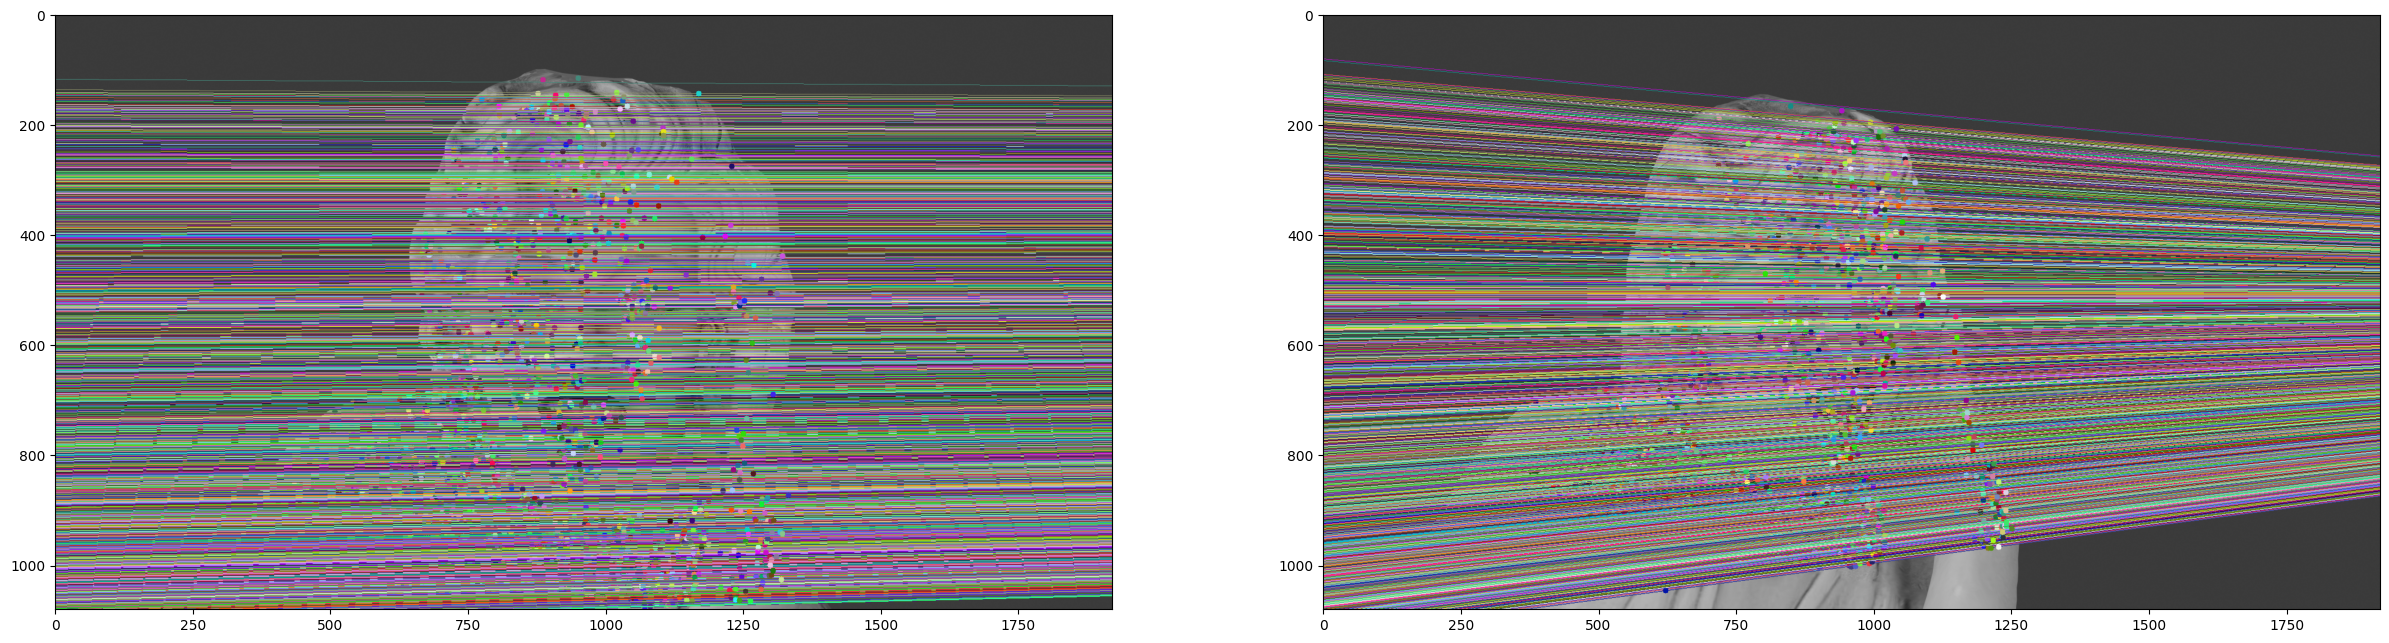

Final number of point matches: 2330
(2330, 2)
(2330, 2)
(2193, 2)
(2193, 2)


In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from math import sin, cos, radians

# Load and preprocess images
img1 = cv.imread("samples/marilyn_front.png", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("samples/marilyn_left.png", cv.IMREAD_GRAYSCALE)

# Create SIFT detector with custom parameters for more keypoints
sift = cv.SIFT_create(
    nfeatures=0,  # Maximum number of features (0 = unlimited)
    nOctaveLayers=3,
    contrastThreshold=0.002,  # Lower threshold = more keypoints (default is 0.04)
    edgeThreshold=16,  # Higher threshold = more keypoints (default is 10)
    sigma=1.6,
)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

print(f"Keypoints in image 1: {len(kp1)}")
print(f"Keypoints in image 2: {len(kp2)}")

# FLANN parameters - slightly modified for better performance
FLANN_INDEX_KDTREE = 4
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=4)  # Increased from 5
search_params = dict(checks=120)  # Increased from 50

flann = cv.FlannBasedMatcher(index_params, search_params)

# Cross-check matching for better results
matches1to2 = flann.knnMatch(des1, des2, k=2)
matches2to1 = flann.knnMatch(des2, des1, k=2)

# Apply ratio test with a higher threshold (0.85 instead of 0.8)
ratio_thresh = 0.88

# First direction (1 to 2)
good_matches1to2 = []
pts1_temp = []
pts2_temp = []

for i, (m, n) in enumerate(matches1to2):
    if m.distance < ratio_thresh * n.distance:
        good_matches1to2.append(m)
        pts1_temp.append(kp1[m.queryIdx].pt)
        pts2_temp.append(kp2[m.trainIdx].pt)

good_matches2to1 = []
for i, (m, n) in enumerate(matches2to1):
    if m.distance < ratio_thresh * n.distance:
        good_matches2to1.append(m)

pts1 = pts1_temp
pts2 = pts2_temp

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

print(f"Number of matches before RANSAC: {len(pts1)}")

# Use RANSAC with a more lenient threshold to keep more matches
F, mask = cv.findFundamentalMat(
    pts1,
    pts2,
    method=cv.FM_RANSAC,
    ransacReprojThreshold=20.0,  # Default is 3.0, higher = more matches
    confidence=0.99,
)  # Higher confidence = more iterations

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]


# Rest of your code remains the same
def drawlines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2


# Find epilines corresponding to points in right image and drawing lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image and drawing lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(30, 18))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

print(f"Final number of point matches: {len(pts1)}")

# Reshape pts1 to structured array for duplicate detection
dt = np.dtype([("f0", pts1.dtype), ("f1", pts1.dtype)])
pts1_reshaped = pts1.view(dt).reshape(-1)

# Find duplicate indices (keep first occurrence)
_, idx_unique = np.unique(pts1_reshaped, return_index=True)
idx_all = np.arange(len(pts1))
idx_duplicates = np.setdiff1d(idx_all, idx_unique)

# Remove duplicates from both pts1 and pts2
pts1_clean = np.delete(pts1, idx_duplicates, axis=0)
pts2_clean = np.delete(pts2, idx_duplicates, axis=0)

print(pts1.shape)
print(pts2.shape)
print(pts1_clean.shape)
print(pts2_clean.shape)
pts1 = pts1_clean
pts2 = pts2_clean

pts1_left = pts1.copy()
pts2_left = pts2.copy()

Keypoints in image 1: 11282
Keypoints in image 2: 11099
Number of matches before RANSAC: 2765


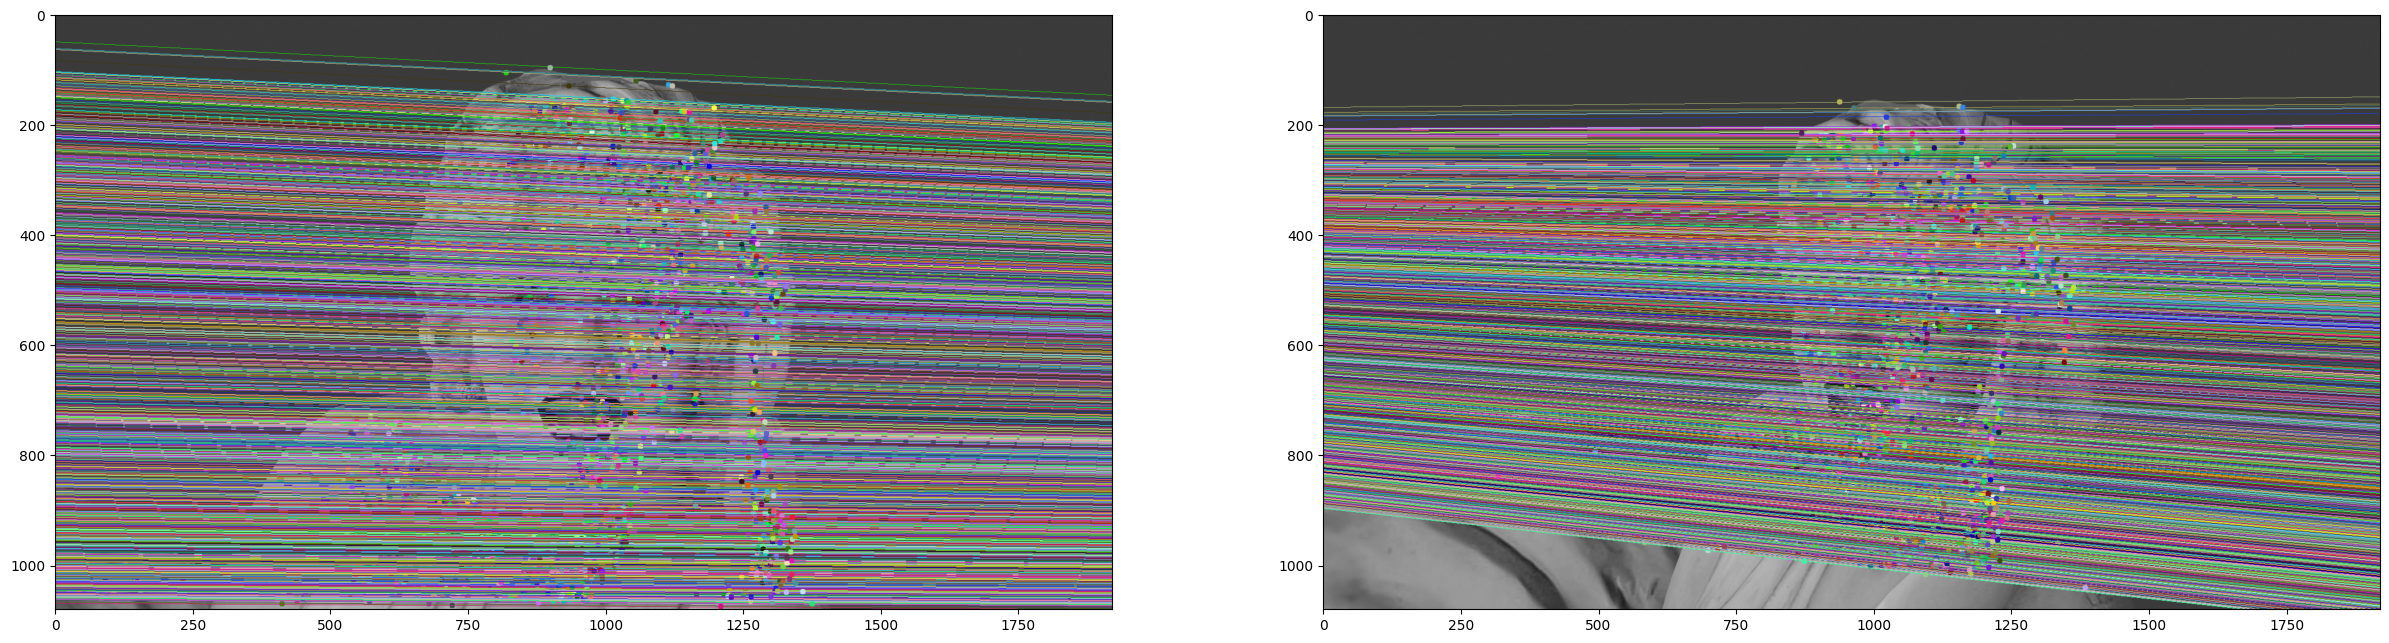

Final number of point matches: 1907
(1907, 2)
(1907, 2)
(1797, 2)
(1797, 2)


In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from math import sin, cos, radians

# Load and preprocess images
img1 = cv.imread("samples/marilyn_front.png", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("samples/marilyn_right.png", cv.IMREAD_GRAYSCALE)

# Create SIFT detector with custom parameters for more keypoints
sift = cv.SIFT_create(
    nfeatures=0,  # Maximum number of features (0 = unlimited)
    nOctaveLayers=3,
    contrastThreshold=0.002,  # Lower threshold = more keypoints (default is 0.04)
    edgeThreshold=16,  # Higher threshold = more keypoints (default is 10)
    sigma=1.6,
)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

print(f"Keypoints in image 1: {len(kp1)}")
print(f"Keypoints in image 2: {len(kp2)}")

# FLANN parameters - slightly modified for better performance
FLANN_INDEX_KDTREE = 4
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=4)  # Increased from 5
search_params = dict(checks=120)  # Increased from 50

flann = cv.FlannBasedMatcher(index_params, search_params)

# Cross-check matching for better results
matches1to2 = flann.knnMatch(des1, des2, k=2)
matches2to1 = flann.knnMatch(des2, des1, k=2)

# Apply ratio test with a higher threshold (0.85 instead of 0.8)
ratio_thresh = 0.88

# First direction (1 to 2)
good_matches1to2 = []
pts1_temp = []
pts2_temp = []

for i, (m, n) in enumerate(matches1to2):
    if m.distance < ratio_thresh * n.distance:
        good_matches1to2.append(m)
        pts1_temp.append(kp1[m.queryIdx].pt)
        pts2_temp.append(kp2[m.trainIdx].pt)

good_matches2to1 = []
for i, (m, n) in enumerate(matches2to1):
    if m.distance < ratio_thresh * n.distance:
        good_matches2to1.append(m)

pts1 = pts1_temp
pts2 = pts2_temp

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

print(f"Number of matches before RANSAC: {len(pts1)}")

# Use RANSAC with a more lenient threshold to keep more matches
F, mask = cv.findFundamentalMat(
    pts1,
    pts2,
    method=cv.FM_RANSAC,
    ransacReprojThreshold=20.0,  # Default is 3.0, higher = more matches
    confidence=0.99,
)  # Higher confidence = more iterations

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]


# Rest of your code remains the same
def drawlines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2


# Find epilines corresponding to points in right image and drawing lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image and drawing lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(30, 18))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

print(f"Final number of point matches: {len(pts1)}")

# Reshape pts1 to structured array for duplicate detection
dt = np.dtype([("f0", pts1.dtype), ("f1", pts1.dtype)])
pts1_reshaped = pts1.view(dt).reshape(-1)

# Find duplicate indices (keep first occurrence)
_, idx_unique = np.unique(pts1_reshaped, return_index=True)
idx_all = np.arange(len(pts1))
idx_duplicates = np.setdiff1d(idx_all, idx_unique)

# Remove duplicates from both pts1 and pts2
pts1_clean = np.delete(pts1, idx_duplicates, axis=0)
pts2_clean = np.delete(pts2, idx_duplicates, axis=0)

print(pts1.shape)
print(pts2.shape)
print(pts1_clean.shape)
print(pts2_clean.shape)
pts1 = pts1_clean
pts2 = pts2_clean

pts1_right = pts1.copy()
pts2_right = pts2.copy()

In [3]:
dt = np.dtype([("f0", pts1_left.dtype), ("f1", pts1_left.dtype)])

# Convert to structured arrays
left_structured = pts1_left.view(dt).reshape(-1)
right_structured = pts1_right.view(dt).reshape(-1)

# Find common elements
common = np.intersect1d(left_structured, right_structured)

# Remove mutual elements from each array
unique_left = np.setdiff1d(left_structured, common)
unique_right = np.setdiff1d(right_structured, common)

# Merge and reshape to original 2D format
merged_structured = np.concatenate((unique_left, unique_right))
merged_structured = np.concatenate((merged_structured, common))
merged_2d = merged_structured.view(pts1_left.dtype).reshape(-1, 2)

common_2d = common.view(pts1_left.dtype).reshape(-1, 2)

pts_left = unique_left
pts_right = np.concatenate((unique_right, common))

print("Merged array without mutual elements:")
print(merged_2d)


pts2_left_structured = pts2_left.view(dt).reshape(-1)
# Find indices of common elements in left_structured
common_indices = np.nonzero(np.in1d(left_structured, common))[0]

# Remove elements at these indices from pts2_left_structured
filtered_pts2_left_structured = np.delete(pts2_left_structured, common_indices)

# Optional: reshape to 2D if needed
filtered_pts2_left_2d = filtered_pts2_left_structured.view(pts1_left.dtype).reshape(
    -1, 2
)

Merged array without mutual elements:
[[   6  975]
 [ 182 1059]
 [ 254 1037]
 ...
 [1311  507]
 [1317  940]
 [1321  943]]


In [4]:
# Convert to structured array
# filtered_structured = filtered_pts2_left_2d.view(dt).reshape(-1)

# Check for duplicates
_, idx, counts = np.unique(right_structured, return_index=True, return_counts=True)
has_duplicates = np.any(counts > 1)
print("Contains mutual (duplicate) elements:", has_duplicates)

Contains mutual (duplicate) elements: False


In [5]:
print(filtered_pts2_left_2d.shape)
print(pts2_left_structured.shape)
print(left_structured.shape)
print(common.shape)
print(common_indices.shape)

(1521, 2)
(2193,)
(2193,)
(672,)
(672,)


In [6]:
# dpi = 100
# width_in = 1920 / dpi
# height_in = 1080 / dpi
# plt.figure(figsize=(width_in, height_in), dpi=dpi)


# plt.scatter(common_2d[:, 0], common_2d[:, 1], c="r", marker="o")

# # Define fixed axis limits
# xlim = (0, 1920)
# ylim = (0, 1080)

# plt.xlim(xlim)
# plt.ylim(ylim[::-1])  # Invert y-axis

# # Set major ticks every 200 units
# plt.xticks(range(xlim[0], xlim[1] + 1, 200))
# plt.yticks(range(ylim[0], ylim[1] + 1, 200))

# # Set minor ticks every 50 units
# plt.gca().set_xticks(range(xlim[0], xlim[1] + 1, 50), minor=True)
# plt.gca().set_yticks(range(ylim[0], ylim[1] + 1, 50), minor=True)

# # Draw grid for both major and minor ticks
# plt.grid(which="major", color="gray", linestyle="-", linewidth=0.8)
# plt.grid(which="minor", color="gray", linestyle="--", linewidth=0.3)

# plt.title("2D Plot of pts1")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.axis("equal")
# plt.tight_layout()
# plt.show()

In [7]:
# from scipy.spatial import Delaunay

# dpi = 100
# width_in = 1920 / dpi
# height_in = 1080 / dpi
# plt.figure(figsize=(width_in, height_in), dpi=dpi)
# # Example: replace with your actual points (Nx2 array)
# points = merged_2d

# # Compute Delaunay triangulation
# tri = Delaunay(points)

# # Define fixed axis limits
# xlim = (0, 1920)
# ylim = (0, 1080)

# plt.xlim(xlim)
# plt.ylim(ylim[::-1])  # Invert y-axis

# # Set major ticks every 200 units
# plt.xticks(range(xlim[0], xlim[1] + 1, 200))
# plt.yticks(range(ylim[0], ylim[1] + 1, 200))

# # Plot result
# plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy())
# plt.plot(points[:, 0], points[:, 1], "o", color="red")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.title("Delaunay Triangulation Mesh")
# plt.show()

In [1]:
# Camera intrinsics
focal_length_mm = 50
sensor_width_mm = 36
image_width_px = 1920
image_height_px = 1080

# Calculate focal length in pixels
focal_length_px = (focal_length_mm / sensor_width_mm) * image_width_px

# Camera intrinsics matrix
K = np.array(
    [
        [focal_length_px, 0, image_width_px / 2],
        [0, focal_length_px, image_height_px / 2],
        [0, 0, 1],
    ]
)

NameError: name 'np' is not defined

In [ ]:
R1_left = cv.Rodrigues(np.deg2rad([15, 0, 0]))[0]
t1_left = np.array([[0], [0], [-1]])

R2_left = cv.Rodrigues(np.deg2rad([-30, 0, 0]))[0]
t2_left = np.array([[-0.5], [0], [-1]])

# Projection matrices
P1_left = K @ np.hstack((R1_left, t1_left))  # Projection matrix for the first camera
P2_left = K @ np.hstack((R2_left, t2_left))  # Projection matrix for the second camera

pts1_left = np.array(pts1_left, dtype=np.float32)  # 2D points from image 1
pts2_left = np.array(pts2_left, dtype=np.float32)  # 2D points from image 2

# Convert to homogeneous coordinates
pts1_hom_left = cv.convertPointsToHomogeneous(pts1_left).reshape(-1, 3)  # shape (N, 3)
pts2_hom_left = cv.convertPointsToHomogeneous(pts2_left).reshape(-1, 3)  # shape (N, 3)

# Triangulation
points_4D_left = cv.triangulatePoints(
    P1_left, P2_left, pts1_hom_left[:, :2].T, pts2_hom_left[:, :2].T
)  # shape (4, N)

# Normalize to convert to 3D coordinates
points_3D_left = points_4D_left[:3] / points_4D_left[3]  # Normalize by the last row

In [30]:
R1_right = cv.Rodrigues(np.deg2rad([-15, 0, 0]))[0]
t1_right = np.array([[0], [0], [-1]])

R2_right = cv.Rodrigues(np.deg2rad([30, 0, 0]))[0]
t2_right = np.array([[0.5], [0], [-1]])

# Projection matrices
P1_right = K @ np.hstack((R1_right, t1_right))  # Projection matrix for the first camera
P2_right = K @ np.hstack(
    (R2_right, t2_right)
)  # Projection matrix for the second camera

pts1_right = np.array(pts1_right, dtype=np.float32)  # 2D points from image 1
pts2_right = np.array(pts2_right, dtype=np.float32)  # 2D points from image 2

# Convert to homogeneous coordinates
pts1_hom_right = cv.convertPointsToHomogeneous(pts1_right).reshape(
    -1, 3
)  # shape (N, 3)
pts2_hom_right = cv.convertPointsToHomogeneous(pts2_right).reshape(
    -1, 3
)  # shape (N, 3)

# Triangulation
points_4D_right = cv.triangulatePoints(
    P1_right, P2_right, pts1_hom_right[:, :2].T, pts2_hom_right[:, :2].T
)  # shape (4, N)

# Normalize to convert to 3D coordinates
points_3D_right = points_4D_right[:3] / points_4D_right[3]  # Normalize by the last row

In [31]:
# Define rotation angle (in degrees or radians)
theta = np.deg2rad(-30)  # Replace with your desired angle

# Rotation matrix around y-axis
Ry = np.array(
    [[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]]
)

# Apply rotation
points_3D_left = Ry @ points_3D_left
# Define rotation angle (in degrees or radians)
theta = np.deg2rad(30)  # Replace with your desired angle

# Rotation matrix around y-axis
Ry = np.array(
    [[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]]
)

# Apply rotation
points_3D_right = Ry @ points_3D_right

In [32]:
%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Scatter plot of the 3D points
ax.scatter(points_3D_left[0], points_3D_left[1], points_3D_left[2], c="b", marker="o")
ax.scatter(points_3D_right[0], points_3D_right[1], points_3D_right[2], c="r", marker="o")

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Points Reconstruction")

plt.show()

In [ ]:
# %matplotlib qt

# from mpl_toolkits.mplot3d import Axes3D


# merged_3D = np.concatenate((points_3D_left, points_3D_right), axis=1)


# plt.figure(figsize=(10, 7))
# ax = plt.axes(projection="3d")

# # Scatter plot of the 3D points
# ax.scatter(merged_3D[0], merged_3D[1], merged_3D[2], c="b", marker="o")

# ax.set_xlabel("X Coordinate")
# ax.set_ylabel("Y Coordinate")
# ax.set_zlabel("Z Coordinate")
# ax.set_title("3D Points Reconstruction")

# plt.show()